# Gold Code from Scratch
### Aaron J. Heller, SRI International, Menlo Park, CA
#### 20 November 2020 (last revision 30 January 2021)
----------

### Introduction
A Gold code, also known as Gold sequence, is a type of pseudo-random binary sequence, used in telecommunication (CDMA) and satellite navigation (GPS). A set of Gold code sequences consists of $2^n + 1$ sequences each one with a period of $2^n - 1$. They have three properties that are useful when multiple devices are broadcasting in the same frequency range. 

1. a set contains many sequences
1. each sequence has close to ideal ("thumbtack") autocorrelation
1. within a set, all pairs of sequences have bounded small, three-valued, cross-correlations

A set of Gold Code sequences are produced by XOR'ing two maximum-length sequences (MLSs, a.k.a. m-sequences) with various relative phases (initial contents of the shift register) between the two sequences. We observe that the cross-correlation between some pairs is lower than others. These are called as _preferred pairs_.  Tables of preferred pairs can be found in the GPS and CDMA standards, but we want to generate sequences that are longer than the ones used by those systems.  We also want to understand how to do this ourselves from scratch. 

### The Three-valued Cross-Correlation Theorem
Gold [[1967]](https://doi.org/10.1109/TIT.1967.1054048) proves what some authors call the "three-valued cross-correlation theorem" that allows us to generate preferred pairs of m-sequences that have 3-valued cyclic cross-correlations.

$$
\begin{align*}
R_{XY} &= \
\begin{cases}
-1 &       2^{n-1} - 1 \text{ times} \\
-t(n) & 2^{n-2} - 2^{j-2} \text{ times} \\
t(n)-2 & 2^{n-2} + 2^{j-2} \text{ times}
\end{cases} 
\\
\\
t(n) &=2^j + 1 \\
\\ %
j &= %
\begin{cases}
    (n+1)/2, & \text{for } n \text{ odd }\\
    (n+2)/2, & \text{for } n \text{ even and } n \not\equiv 0 \mod 4\\
\end{cases}
\end{align*}
$$

where $n$ is the order of the generator polynomial. This holds for two m-sequences exactly, and approximately for Gold sequences.

To do this, we start with an initial m-sequence, $S(x)$, of the desired periodicity, $2^n-1$, and decimate it by $q$, $S'(x) = S(x)[q].$  If the degree of $S$'s generator polynomial, $n$, and the decimation factor, $q$, have the properties listed below, the two sequences, $S$ and $S'$, will be a preferred pair. If needed, the generator polynomial for the decimated sequence can be found using the Berlekamp-Massey [[1969]](https://doi.org/10.1109/TIT.1969.1054260) or the Reeds-Sloane [[1985]](https://doi.org/10.1137/0214038) algorithms.

### Required properties of $n$ and $q$ for preferred pairs

1. $$n \not\equiv 0 \mod 4 \tag{3}$$
2. $$q \text{ is odd and of the form } q=2^k + 1 \text{ or } q=2^{2k}-2k+1 \text{ for some } k\tag{4}$$
3. $$ 
\gcd(n, k) = \ %
\begin{cases}
      1, & \text{for odd}\ n \\ %
      2, & \text{for even}\ n %
\end{cases}
\tag{5}
$$

### Kasami Sequences

[Kasami Sequences](https://en.wikipedia.org/wiki/Kasami_code) are binary sequences of length $2^n-1$ with $n$ even.  They have cross-correlation bounds approaching the Welch limit [[1974]](https://doi.org/10.1109/TIT.1974.1055219).  The Welch limit establishes the theoretical lower bounds on cross-correlation of a set of sequences. 

#### The small set
The small Kasami set produced using a preferred pair, $S$ and $S'$, where $S'(x)=S(x)[q]$, where $q= 2^{j/2} + 1$ with $j$ even. 

#### The large set 
FIXME: For Kasami codes, we XOR three m-sequences, two that comprise a preferred pair and a third, which is a decimation of one of the sequences in the preferred pair, where $q = 2^{j/2} + 1$ with $j$ even.

### Roughly...

Paraphrasing Rothaus[[1993]](https://doi.org/10.1109/18.212299), Gold constructs, roughly:
* $2^n$ codes of length $2^n$ with all cross-correlations less than $2^{n/2}$. 
* for $n$ odd, $2^{2n}$ codes of length $2^n$ with all cross-correlations less than $2\cdot 2^{n/2}$ 
* $2^{3n}$ codes of length $2^n$ with cross-correlations less than $4 \cdot 2^{n/2}$, 
* $2^{4n}$ codes with cross-correlations less than $8 \cdot 2^{n2}$, etc. 

Kasami constructs (large codes) for $n$ even, roughly:
* $2^{3n/2}$ codes of length $2^n$ with cross-correlations less than $2^{n/2}$
* $2^{5n/2}$ codes of length $2^n$ with cross-correlations less than $2\cdot 2^{n/2}$ 
* $2^{7n/2}$ codes with cross-correlations less than $4\cdot 2^{n/2}$
* etc.

In [3]:
from itertools import count, chain, islice
from math import gcd


def t(n):
    """Return upper bound on absolute cross-correlation of two different members of a Gold Code set."""
    if n % 2 != 0:
        return 2**((n+1)/2) + 1
    elif n % 4 != 0:
        return 2**((n+2)/2) + 1
    else:
        return None
    
def theta(n):
    """Return the three-values of absolute cross-correlation of two different members of a Gold Code set."""
    t_n = t(n)
    return -t_n, -1, t_n-2

def Rxy(n):
    if n % 4 == 0:
        raise ValueError(f"{n} == 0 mod 4")
    if n % 2 == 1:
        j = (n + 1) / 2  # n is odd
    else:
        j = (n + 2) / 2  # n is even
    return {-1: 2**(n-1)-1,
            -1 - 2**j: 2**(n-2) - 2**(j-2),
            -1 + 2**j: 2**(n-2) + 2**(j-2)}
    

def q_generator(n, q_fn=1):
    """Generate good values of q, the decimation factor, for a given n.
    """
    
    # allow short hand for q(k)
    if q_fn == 1:
        q_fn = lambda k: 2**k + 1
    elif q_fn == 2:
        q_fn = lambda k: 2**(2*k) - 2*k + 1
 
    # try out q_fn to see if it is really a function
    q_fn(1)
    
    # property 1
    if n % 4 == 0:
        raise ValueError("n mod 4 is 0!")
     
    # length of m-sequence
    N = 2**n - 1

    # good GCD for property 3
    good_gcd = 1 if n%2 == 1 else 2

    qs = set()
    for k in count():
        # checking property 3
        if gcd(n, k) != good_gcd:
            continue

        # property 2
        q = q_fn(k)

        # the decimation is cyclic, so if we've cycled around, we're done
        q_mod_N = q % N
        if q_mod_N % 2 == 1:  # property 3, q is odd
            if q_mod_N in qs:
                break
            else:
                yield q_mod_N
                qs.add(q_mod_N)
                
def generate_good_qs(n):
    return chain(q_generator(n, 1), q_generator(n, 2))

# utility function to get nth item from a non-indexable, such the generator returned by generate_good_qs
def nth(iterable, n, default=None):
        "Returns the nth item or a default value"
        return next(islice(iterable, n, None), default)

In [8]:
Rxy(13), (2016*(-129) + 2080*127 - 4095)

({-1: 4095, -129.0: 2016.0, 127.0: 2080.0}, 1)

In [6]:
sorted(generate_good_qs(13))

[3,
 3,
 5,
 5,
 7,
 9,
 13,
 15,
 17,
 31,
 33,
 33,
 41,
 57,
 59,
 65,
 67,
 83,
 93,
 109,
 119,
 129,
 145,
 171,
 197,
 223,
 249,
 257,
 283,
 309,
 335,
 361,
 387,
 413,
 439,
 465,
 491,
 513,
 807,
 833,
 859,
 885,
 911,
 937,
 963,
 989,
 1015,
 1025,
 1817,
 1843,
 1869,
 1895,
 1921,
 1947,
 1973,
 1999,
 2025,
 2049,
 3877,
 3903,
 3929,
 3955,
 3981,
 4007,
 4033,
 4059,
 4085,
 4097]

## M-Sequences
A maximum length sequence (MLS) is a type of pseudorandom binary sequence. They are binary sequences generated by a linear-feedback shift register, with particular feedback taps. They are periodic and maximum-length in the sense that the shift register cycles though every possible state, except the all zero state, before repeating. The criteria for being maxmimum-length is that the feedback taps correspond to the non-zero terms of a primative polynomial over GF(2).

[Wikipedia MLS](https://en.wikipedia.org/wiki/Maximum_length_sequence)

### Cyclic Decimation of M-Sequences

A property of m-sequences is that cyclic decimation by any non-zero factor results in another m-sequence.  The length of the resulting sequence will be ${N}/{\gcd(N, q)}$, where $N$ is the length of the original sequence ($=2^n - 1$) and $q$ is the decimation factor.  A corollary is that if $\gcd(N, q) = 1$ the resulting sequences is the same length as the original.

The generator polynomial for the second sequence in the preferred pair can be obtained using the Berlekamp-Massey algorithm. [discussion here](https://stackoverflow.com/questions/718190/how-can-you-find-the-polynomial-for-a-decimated-lfsr)

Remaining questions:
* Is there a way to get the generator polynomial for the second sequence directly from the first polynomial and decimation factor?
* [yes, maybe](https://web.archive.org/web/20170830000819/https://paginas.fe.up.pt/~hmiranda/cm/Pseudo_Noise_Sequences.pdf)
"The decimation by $n>0$ of a m-sequence $c$, denoted as $c[n]$, has a period equal to $N/\gcd(N,n)$, if it is not the all-zero sequence, its generator polynomial $g'(x)$ has roots that are $n^{th}$ powers of the roots of $g(x)$" 
* this makes sense to me by analogy with $e^{i n \theta}$ advancing around the circle n times faster
* if not, we can take the decimated sequence and use Berlekamp-Massey to get the taps. 

### Charateristic Phase of M-Sequences

Phase referes to the starting index of the M-sequence, which is determined by the initial contents of the shift register.  The *characteristic phase* is the phase for which a cyclic decimation by 2 results in the same sequence. 

In [31]:
import numpy as np
from scipy import signal as sig

def decimate_sequence(s, q):
    """Return cyclic decimation of the sequence s by the factor q."""
    N = len(s)
    i = np.mod(np.arange(N) * q, N)
    s_ = s[i]
    return s_


def characteristic_phase(s):
    """Find the characteristic phase of an M-sequence."""
    for i in range(len(s)):
        s0 = np.roll(s, i)
        s1 = decimate_sequence(s0, 2)
        if np.all(s0 == s1):
            #print(i)
            break
    else:
        print("no cp found!")
    return i

def test_characteristic_phase(n):
    s = sig.max_len_seq(n)[0]

    cp = characteristic_phase(s)
    return len(s), cp
    

In [39]:
for n in range(2, 18):
    nn, cp = test_characteristic_phase(n)
    print(nn, cp)

3 1
7 0
15 1
31 18
63 1
127 0
255 247
511 130
1023 70
2047 1029
4095 2277
8191 822
16383 12856
32767 0
65535 17697
131071 9283


### Gold Codes

To generate a Gold Code set, we need a preferred pair of m-sequences:
1. Generate an m-sequence, $S_1$
2. Select a "good" value for $q$
3. Decimate $S_1$ by $q$ to produce a second sequence, $S_2$.  $S_1$ and $S_2$ comprise a preferred pair.
4. XOR $S_1$ and various phases of $S_2$
5. Augment the set with $S_1$ and $S_2$, if needed

Additionally, we may want to check that resulting sequence is balanced. 

TODO: 
* There is a way to pick phases that result in balanced sequences, but since roughly 40 percent are balanced, generate-and-test is good enough for now.
* The above involves the idea of the _characteristic phase_ of a M-sequence [[Kirkman and Rice, 1992]](https://doi.org/10.1109/ICASSP.1992.226298).

In [2]:
import numpy as np
from scipy import signal as sig

def gold_code_set(n, set_size, q=None, 
                  bipolar=True, 
                  include_pair=True, 
                  initial_phase=None):
    """Generate a Gold Code set."""
    if q is None:
        q = next(generate_good_qs(n))
    
    # the default sequence for length n
    s1 = sig.max_len_seq(n)[0]
    # the second sequence, forming a preferred pair with s1
    s2 = decimate_sequence(s1, q)
    
    gc_set = np.row_stack((s1, s2, 
                          [np.logical_xor(s1, np.roll(s2, p))
                            for p in range((n+1), (n+1)+set_size-2)]
                          ))
    if bipolar:
        gc_set = gc_set * 2 - 1
        
    return gc_set

def to_bipolar(s):
    return s * 2 - 1

def is_sequence_balanced(s, tolerance=1):
    vals, counts = np.unique(s, return_counts=True)
    bal = abs(counts[1] - counts[0]) <= tolerance
    return bal

### Test case with $n = 15$

In [27]:
n = 15
set_size = 128

gc_set = gold_code_set(n, set_size, bipolar=True)
print(gc_set.shape, gc_set.dtype)

# how many of these are balanced?
bal = [is_sequence_balanced(s) for s in gc_set]
print(np.mean(bal))

(128, 32767) int8
0.4296875


In [4]:
# save the set, transpose to a given member is in a column.
np.savetxt(f"gc_set_n{n}.csv", gc_set.transpose()>0, fmt="%d", delimiter=",")

### Cyclic cross corrlelation

In [5]:
from numpy.fft import fft, ifft, ihfft
from scipy.fft import fft as sfft

def cyclic_xcorr(x, y):
    """Periodic correlation, implemented using the FFT.

    x and y must be real sequences with the same length.
    """
    return ifft(fft(x) * fft(y).conj()).real

def cyclic_xcorr_all(x_set, axis=1):
    X = sfft(x_set, axis=axis, workers=cpu_count())  # assume x is a 2-D array with the signals in the rows

    xcorr = np.empty((X.shape[0], X.shape[0], X.shape[1]))
    for i, x in enumerate(X):
        for j, y in enumerate(X):
            xcorr[i, j] = ifft(x * y.conj()).real
    return xcorr

# using map
import itertools
def cyclic_xcorr_all_map(x_set):
    X = sfft(x_set, workers=cpu_count())
    xc = map(lambda x, y: ifft(x * y.conj()).real,
             *zip(*itertools.product(X, repeat=2)))
    return xc

# parallel using joblib
from joblib import Parallel, delayed, cpu_count

def cyclic_xcorr_all_parallel(gc_set, n_jobs=None):
    if n_jobs is None:
        n_jobs = cpu_count()//2  # hyperthreading doesn't help with this
        
    X = sfft(gc_set, workers=n_jobs)
    xc = (Parallel(n_jobs=n_jobs, verbose=1,  prefer="threads")
          (delayed(lambda x: ifft(x).real)((x * y.conj())) 
           for x in X for y in X))
    return xc

In [6]:
# compute cross-correlation for all pairs
from Timer import Timer
with Timer("loop"):
    xcorr_all = cyclic_xcorr_all(gc_set).round(8)

print(xcorr_all.shape)

# what is the maximum for each
max_xcorr_all = np.max(np.abs(xcorr_all), axis=2)

loop: 33.86768889427185
(128, 128, 32767)


In [7]:
from Timer import Timer
with Timer("map") as tt:
    list(cyclic_xcorr_all_map(gc_set))

map: 31.407520055770874


In [8]:
from Timer import Timer

n_jobs = cpu_count()
with Timer(f"parallel njobs={n_jobs}"):
    xxc=np.asarray(cyclic_xcorr_all_parallel(gc_set, n_jobs=n_jobs)).reshape((set_size, set_size, -1))
xxc.shape

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.5s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:    0.8s
[Parallel(n_jobs=12)]: Done 1776 tasks      | elapsed:    1.1s
[Parallel(n_jobs=12)]: Done 2426 tasks      | elapsed:    1.4s
[Parallel(n_jobs=12)]: Done 3176 tasks      | elapsed:    1.8s
[Parallel(n_jobs=12)]: Done 4026 tasks      | elapsed:    2.3s
[Parallel(n_jobs=12)]: Done 4976 tasks      | elapsed:    2.8s
[Parallel(n_jobs=12)]: Done 6026 tasks      | elapsed:    3.3s
[Parallel(n_jobs=12)]: Done 7176 tasks      | elapsed:    3.9s
[Parallel(n_jobs=12)]: Done 8426 tasks      | elapsed:    4.6s
[Parallel(n_jobs=12)]: Done 9776 tasks      | elapsed:    5.3s
[Parallel(n_jobs=12)]: Done 11226 tasks 

parallel njobs=12: 12.632782697677612


(128, 128, 32767)

In [9]:
print(Rxy(n))
xcc = xxc.round().astype(np.int32)

{-1: 16383, -257.0: 8128.0, 255.0: 8256.0}


In [10]:
np.unique(xcc[2][3], return_counts=True)

(array([-257,   -1,  255], dtype=int32), array([ 8132, 16374,  8261]))

True


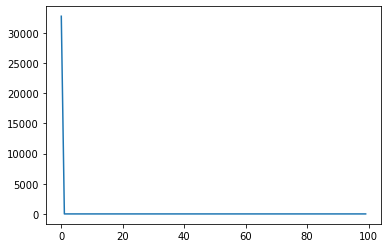

In [11]:
# what happens if we use a 'bad' q
# surprizingly we get the same sequence!

from matplotlib import pyplot as plt
s1 = gc_set[0]
s2 = decimate_sequence(s1, 2)
print(np.all(s1==s2))
plt.plot(cyclic_xcorr(s1, s2)[:100])

### Does balance affect the autocorrelation?
Looks like it does not... but we might want balanced sequences for other reasons.

In [12]:
# balance vs. autocorrelation  
[(is_sequence_balanced(gc), np.unique(x[i]))
 for i, (gc, x) in enumerate(zip(gc_set, xcc))]

[(True, array([   -1, 32767], dtype=int32)),
 (True, array([   -1, 32767], dtype=int32)),
 (False, array([ -257,    -1,   255, 32767], dtype=int32)),
 (True, array([ -257,    -1,   255, 32767], dtype=int32)),
 (False, array([ -257,    -1,   255, 32767], dtype=int32)),
 (True, array([ -257,    -1,   255, 32767], dtype=int32)),
 (False, array([ -257,    -1,   255, 32767], dtype=int32)),
 (True, array([ -257,    -1,   255, 32767], dtype=int32)),
 (False, array([ -257,    -1,   255, 32767], dtype=int32)),
 (True, array([ -257,    -1,   255, 32767], dtype=int32)),
 (False, array([ -257,    -1,   255, 32767], dtype=int32)),
 (True, array([ -257,    -1,   255, 32767], dtype=int32)),
 (False, array([ -257,    -1,   255, 32767], dtype=int32)),
 (True, array([ -257,    -1,   255, 32767], dtype=int32)),
 (False, array([ -257,    -1,   255, 32767], dtype=int32)),
 (True, array([ -257,    -1,   255, 32767], dtype=int32)),
 (True, array([ -257,    -1,   255, 32767], dtype=int32)),
 (False, array([ -

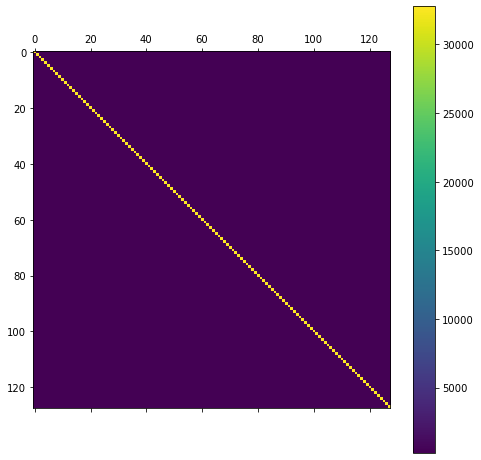

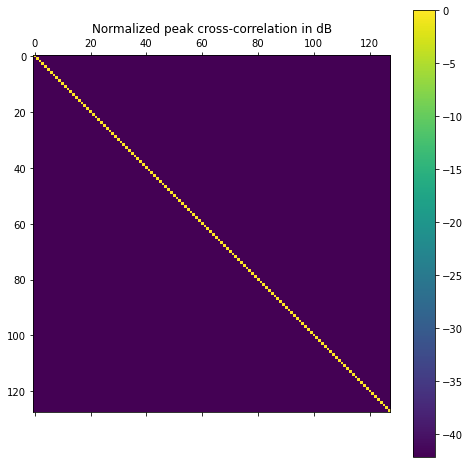

In [13]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

if False:
    plt.figure(1, figsize=(8, 8))
    plt.matshow(max_xcorr_all, 
                fignum=1, 
                norm=colors.LogNorm(vmin=max_xcorr_all.min(), 
                                    vmax=max_xcorr_all.max()))
    plt.title("Log-maximum cross-correlation of the family of Gold Codes")
    plt.colorbar()
    plt.show()

plt.figure(2, figsize=(8, 8))
plt.matshow(max_xcorr_all, fignum=2)
plt.colorbar()
plt.show()

plt.figure(3, figsize=(8, 8))
plt.matshow(20*(np.log10(max_xcorr_all)-np.log10(2**n - 1)), fignum=3)
plt.title("Normalized peak cross-correlation in dB")
plt.colorbar()
plt.show()

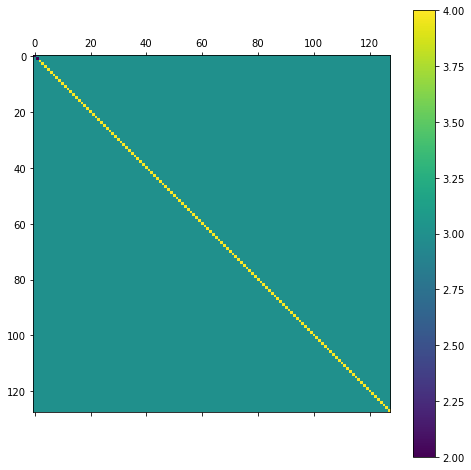

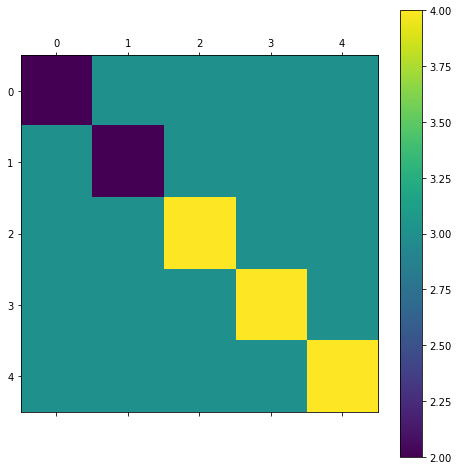

In [14]:
# how many unique values in each cross-correlation?
#  see McEliece, Theorem 11.15

c = np.asarray([[len(np.unique(x)) for x in y] for y in xcorr_all])

plt.figure(4, figsize=(8, 8))
plt.matshow(c, fignum=4)
plt.colorbar()
plt.show()

plt.figure(5, figsize=(8, 8))
plt.matshow(c[:5, :5], fignum=5)
plt.colorbar()
plt.show()

### What is the relationship between $R_{xy}$ and $R_{yx}$ ?

They appear to be the reverse of each other.

(128, 32767)
True
32766 32766
True


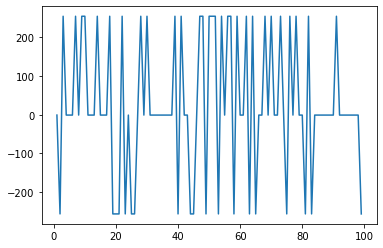

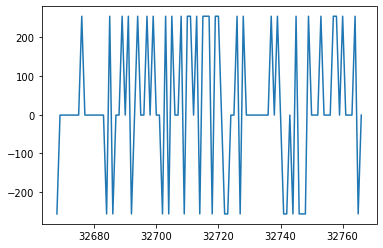

(-257.0, -1, 255.0)

In [15]:
print(gc_set.shape)
Rxy, Ryx = xcorr_all[10, 2, :], xcorr_all[2, 10, :]

s_beg = slice(1, 100)
s_end = slice(-1, -100, -1)

print(len(Rxy[s_beg]) == len(Ryx[s_end]))

print(len(Rxy[1:]), len(Ryx[-1:0:-1]))
print(np.all(Rxy[1:] == Ryx[-1:0:-1]))


plt.plot(np.arange(len(Rxy))[s_beg], Rxy[s_beg])
plt.show()

plt.plot(np.arange(len(Rxy))[s_end], Ryx[s_end])
plt.show()

theta(n)

## M-sequences

In [17]:
# this is somewhat faster than the implementation in sympy
#   http://fredrikj.net/python-flint/nmod_poly.html
#
# install:
# !conda install -c conda-forge python-flint
# or
# !pip install python-flint

    
try:
    import flint
except ImportError as ie:
    flint = False
    print('The package "flint" is not available. Skipping sections that need it.')

from Timer import Timer

def taps_flint(n, algorithm='Cantor-Zassenhaus'):
    N = 2**n - 1
    # construct the poly x**N + 1 (mod 2)
    poly = flint.nmod_poly([1] + [0]*(N-1) + [1], mod=2)
    print(f"{poly}  GF{poly.modulus()}")
    factors = poly.factor(algorithm=algorithm)[1]
    fn = (fac for fac, mult in factors if fac.degree() == n)
    
    taps = [[ex for ex, c in enumerate(fac) if c][-2:1:-1] for fac in fn]
    
    return taps

The package "flint" is not available. Skipping sections that need it.


In [17]:
if flint:
    with Timer("Cantor-Zassenhaus"):
        fac = taps_flint(15, algorithm="Cantor-Zassenhaus")
        print(len(fac))

In [18]:
if flint:
    with Timer('Kaltofen-Shoup'):
        fac2 = taps_flint(15, algorithm='Kaltofen-Shoup')
        print(len(fac2))

### Berlekamp-Massey to find LFSR taps from boolean sequences

Note that Gold Codes are not M-sequences!! Berlekamp-Massey says you need a 2x shift register to make them!

In [19]:
from importlib import reload
import lfsr
reload(lfsr)

# their first two members of the set are the preferred pair of m-sequences
[lfsr.run_berlekamp_massey(s) for s in gc_set[:2]==1]

[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]]

### Feedback Taps for entire Gold Code Set
Using Berlekamp-Massey, we discover that they all use the same taps, and therefore must vary by initial contents of the shift register!

In [20]:
from joblib import delayed, Parallel, cpu_count
gc_taps = np.asarray(Parallel(n_jobs=cpu_count()//2, verbose=5)
                     (delayed(lfsr.run_berlekamp_massey)(s==1) 
                      for s in gc_set[2:]))  # exclude generator pair
gc_taps.shape

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    2.6s
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:   23.3s
[Parallel(n_jobs=6)]: Done 126 out of 126 | elapsed:   51.6s finished


(126, 30)

In [21]:
# are the entries in each column of the array equal... yes!
np.all(np.diff(gc_taps, axis=0)==0)

True

### Feedback Taps of Decimated M-Sequences

In [16]:
import lfsr
import numpy as np

n=13
# the default sequence for length n
s1 = sig.max_len_seq(n)[0]
print(1, lfsr.run_berlekamp_massey(s1==1))
    
for i, q in enumerate(sorted(generate_good_qs(n))):
    s2 = decimate_sequence(s1, q)
    taps = lfsr.run_berlekamp_massey(s2==1)
    hex = np.packbits(np.array(taps, dtype=np.uint8))
    
    print(i, q, taps, hex)

1 [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1]
0 3 [1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0] [137 224]
1 3 [1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0] [137 224]
2 5 [1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0] [143 224]
3 5 [1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0] [143 224]
4 7 [1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1] [159 120]
5 9 [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1] [144  40]
6 13 [1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1] [215 136]
7 15 [1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1] [165  40]
8 17 [1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1] [135  24]
9 31 [1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1] [142  24]
10 33 [1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1] [209 232]
11 33 [1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1] [209 232]
12 41 [1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1] [184  72]
13 57 [1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0] [175  96]
14 59 [1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1] [133 168]
15 65 [1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0] [251 128]
16 67 [1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0] [202  96]
17 83 [1, 1, 0, 0, 0, 

In [49]:
b0, b1=sig.max_len_seq(5, taps=[3])[0], sig.max_len_seq(5)[0]

lfsr.run_berlekamp_massey(b1)

b2 = sig.max_len_seq(5, taps=[4, 3, 2])[0]
b2
bm_taps2=np.asarray(lfsr.run_berlekamp_massey(b2))
print(mb_taps2)
print(np.arange(5)[bm_taps2==1])

b3 = sig.max_len_seq(5, taps=[4, 3, 1])[0]
b3
bm_taps3=np.asarray(lfsr.run_berlekamp_massey(b3))
bm_taps3
print(np.arange(5)[bm_taps3==1])

[1, 0, 1, 1, 1]
[0 2 3 4]
[0 1 3 4]


### Old experiments

In [22]:
import numpy as np
from scipy import signal as sig

n = 15
seq1 = sig.max_len_seq(n)[0]

q = next(generate_good_qs(n))
print(f"q = {q}")

seq2 = decimate_sequence(seq1, q)

print(*theta(n))

q = 3
-257.0 -1 255.0


[-1.0000e+00  3.2767e+04]


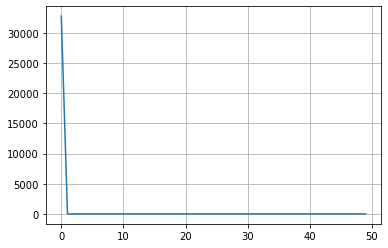

[-257.   -1.  255.]


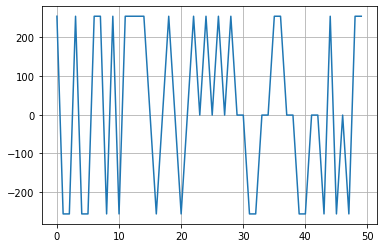

[-257.   -1.  255.]


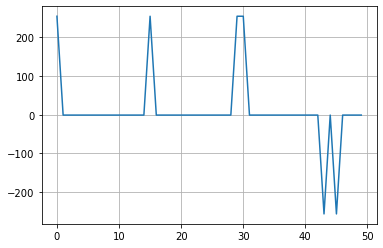

[-1.0000e+00  3.2767e+04]


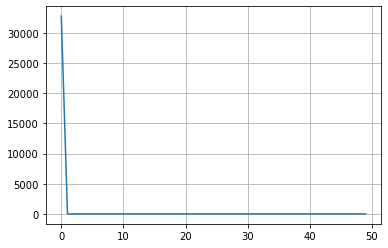

In [23]:
import matplotlib.pyplot as plt

plot_range=slice(None, 50)

for bs1, bs2 in (itertools.product((seq1 * 2 - 1, seq2 * 2 - 1), repeat=2)):
    xcorr = cyclic_xcorr(bs1, bs2)
    print(np.unique(np.around(xcorr, 10)))
    plt.plot(xcorr[plot_range])
    plt.grid(True)
    plt.show()

## Kasami

In [24]:
import numpy as np
from scipy import signal as sig

kn = 16
kpp1 = sig.max_len_seq(kn)[0]

kq = 5 # 2**j + 1, with j even, say 2
print(f"q = {kq}")

kpp2 = decimate_sequence(kpp1, kq)

q = 5


In [25]:
k_set_size = 10
k_set = np.row_stack([np.logical_xor(kpp1, np.roll(kpp2, p))
                      for p in range((kn+1), (kn+1)+k_set_size-2)]
                          )

[-1.0250e+03 -2.5700e+02 -1.0000e+00  2.5500e+02  1.0230e+03  6.5535e+04]


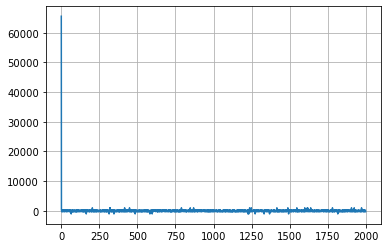

[-1.025e+03 -2.570e+02 -1.000e+00  2.550e+02  1.023e+03]


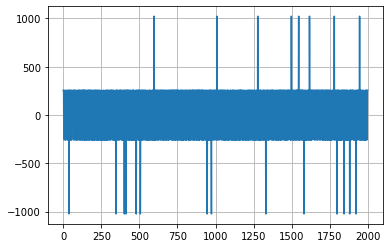

[-1.025e+03 -2.570e+02 -1.000e+00  2.550e+02  1.023e+03]


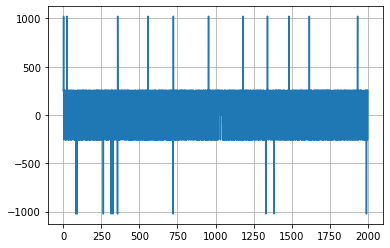

[-1.025e+03 -2.570e+02 -1.000e+00  2.550e+02  1.023e+03]


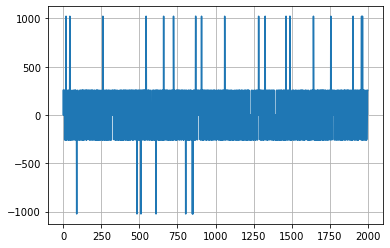

[-1.0250e+03 -2.5700e+02 -1.0000e+00  2.5500e+02  1.0230e+03  6.5535e+04]


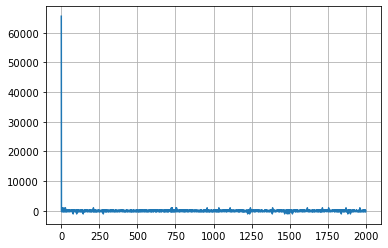

[-1.025e+03 -2.570e+02 -1.000e+00  2.550e+02  1.023e+03]


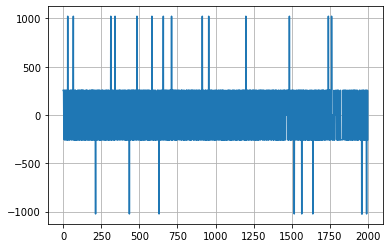

[-1.025e+03 -2.570e+02 -1.000e+00  2.550e+02  1.023e+03]


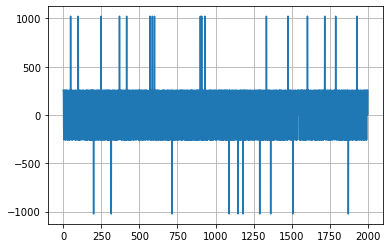

[-1.025e+03 -2.570e+02 -1.000e+00  2.550e+02  1.023e+03]


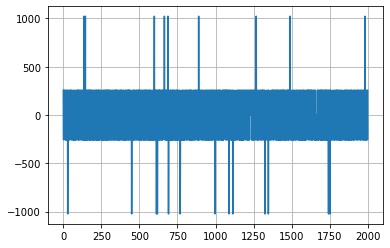

[-1.0250e+03 -2.5700e+02 -1.0000e+00  2.5500e+02  1.0230e+03  6.5535e+04]


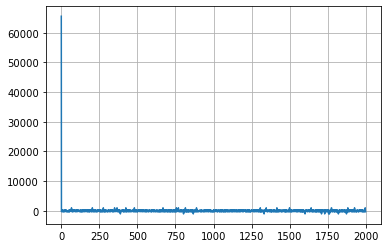

In [26]:
import matplotlib.pyplot as plt

plot_range=slice(None, 2000)

for bs1, bs2 in (itertools.product((k_set[1] * 2 - 1, 
                                    k_set[2] * 2 - 1,
                                    k_set[3] * 2 - 1), repeat=2)):
    xcorr = cyclic_xcorr(bs1, bs2)
    print(np.unique(np.around(xcorr, 10)))
    plt.plot(xcorr[plot_range])
    plt.grid(True)
    plt.show()